In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import chart_studio.plotly as plot_mpl
import plotly.graph_objs as go
import xgboost as xgb
#import keras.backend as K
#import tensorflow as tf

from math import sqrt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
#from pyramid.arima import auto_arima

from socket import socket
from statsmodels.tsa.seasonal import seasonal_decompose

#from keras.models import Sequential
#from keras.layers import Conv1D, LSTM, TimeDistributed, Dense
#from keras.optimizers import Adam
#from keras.callbacks import EarlyStopping

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sqrt', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [91]:
train = pd.read_csv('C:/Users/user/Desktop/VASYA3.csv')

In [4]:
train.dtypes

data    object
RTSI     int64
dtype: object

# Предварительная обработка

In [5]:
train = train.set_index(['data'])

In [6]:
train.index = pd.to_datetime(train.index)

In [7]:
train.dtypes

RTSI    int64
dtype: object

# Стационарный контроль
Если достигаемый уровень знаимости меньше 0,005, мы можем сказать, что есть стационарность, иначе ее нет 

Если в наших данных нет стационарности, я планирую использовать дифференцирование

In [12]:
class Stationary:
    def __init__(self, significance=.005):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

    def ADF_Stationarity_Test(self, timeseries, printResults=True):

        # Критерий Дики-Фуллера:
        print(timeseries)
        try:
            adfTest = adfuller(timeseries, autolag='AIC')

            self.pValue = adfTest[1]

            if (self.pValue < self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False
            #self.isStationary=True
            if printResults:
                dfResults = pd.Series(adfTest[0:4],
                                      index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])

                # Добавить критические значения
                for key, value in adfTest[4].items():
                    dfResults['Critical Value (%s)' % key] = value

                print('Augmented Dickey-Fuller Test Results:')
                print(dfResults)
        except Exception as e:
          print(e)
          self.isStationary = False

In [9]:
sTest = Stationary()

# Создаем дифференцированный ряд 

In [24]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        # print(interval, dataset[i], dataset[i - interval])
        diff.append(value)
    return pd.Series(diff)

In [25]:
diff_values = difference(train['RTSI'], 1)

# разделим данные на тестовую и обучающую 

In [26]:
#xtrain, xtest = diff_values[0:-23], diff_values[-23:]

In [27]:
diff_values = difference(train['RTSI'], 1)

In [28]:
xtrain, xtest = diff_values[0:-23], diff_values[-23:]

# Сформулируем последовательность как задачу обучения с учителем

In [30]:
def timeseries_to_supervised(data, lag=1):
    dfx = pd.DataFrame(data)
    df = dfx.assign(**{
        '{} (t-{})'.format(col, t): dfx[col].shift(t)
        for t in range(lag+1)
        for col in dfx
    })

    df=df.drop([df.columns[0]], axis=1)
    df=df[df.columns[::-1]]
    return df[lag:]

# Масштабируем тренировочные и тестовые данные до [-1, 1] с помощью MinMaxScaler

In [31]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler()  
    
    # StandardScaler()
    scaler = scaler.fit(train)

    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    tr_scaled = scaler.transform(train)

    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    ts_scaled = scaler.transform(test)
    
    return scaler, tr_scaled, ts_scaled

# Реорганизуем набор данных в соответствии с размером окна

In [33]:
values_unscaled = np.concatenate((xtrain, xtest))
supervised_raw = timeseries_to_supervised(values_unscaled, 12)

In [35]:
supervised_raw = supervised_raw.values.astype("float32")

In [36]:
supervised_raw

array([[18., -7., 15., ..., -3.,  0., 10.],
       [-7., 15.,  7., ...,  0., 10., -2.],
       [15.,  7.,  5., ..., 10., -2.,  8.],
       ...,
       [ 0., 13.,  0., ...,  4., 15., -2.],
       [13.,  0., -4., ..., 15., -2.,  9.],
       [ 0., -4., -6., ..., -2.,  9.,  7.]], dtype=float32)

In [37]:
scaler, train_scaled, test_scaled = scale(xtrain.values.reshape(len(xtrain), 1), xtest.values.reshape(len(xtest), 1))

In [38]:
values_scaled = np.concatenate((train_scaled, test_scaled))

In [39]:
supervised = timeseries_to_supervised(values_scaled, 12)

supervised_values = supervised.values.astype('float32')

### разделим контролируемые данные на обучающие и тестовые наборы

In [67]:
supervised_train, supervised_test = supervised_raw[0:-23], supervised_raw[-23:]
train_scaled, test_scaled = supervised_values[0:-23], supervised_values[-23:]

In [40]:
train_scaled

array([[0.66233766, 0.33766234, 0.6233766 , ..., 0.38961038, 0.42857143,
        0.5584416 ],
       [0.33766234, 0.6233766 , 0.5194805 , ..., 0.42857143, 0.5584416 ,
        0.4025974 ],
       [0.6233766 , 0.5194805 , 0.4935065 , ..., 0.5584416 , 0.4025974 ,
        0.53246754],
       ...,
       [0.25974026, 0.38961038, 0.46753246, ..., 0.33766234, 0.53246754,
        0.58441556],
       [0.38961038, 0.46753246, 0.48051947, ..., 0.53246754, 0.58441556,
        0.46753246],
       [0.46753246, 0.48051947, 0.32467532, ..., 0.58441556, 0.46753246,
        0.5064935 ]], dtype=float32)

In [41]:
train_X, train_y = train_scaled[:, :-1], train_scaled[:, -1]
test_X, test_y = test_scaled[:, :-1], test_scaled[:, -1]

In [42]:
train_y.reshape(train_y.shape[0], 1)

array([[0.5584416 ],
       [0.4025974 ],
       [0.53246754],
       [0.2857143 ],
       [0.5974026 ],
       [0.53246754],
       [0.4935065 ],
       [0.41558442],
       [0.44155845],
       [0.6103896 ],
       [0.36363637],
       [0.35064936],
       [0.25974026],
       [0.38961038],
       [0.53246754],
       [0.6103896 ],
       [0.09090909],
       [0.16883117],
       [0.64935064],
       [0.3116883 ],
       [0.32467532],
       [0.5974026 ],
       [0.3116883 ],
       [0.5584416 ],
       [0.45454547],
       [0.44155845],
       [0.44155845],
       [0.44155845],
       [0.35064936],
       [0.38961038],
       [0.37662336],
       [0.6103896 ],
       [0.3116883 ],
       [0.36363637],
       [0.44155845],
       [0.46753246],
       [0.35064936],
       [0.53246754],
       [0.46753246],
       [0.5064935 ],
       [0.54545456],
       [0.45454547],
       [0.32467532],
       [0.4935065 ],
       [0.5194805 ],
       [0.2857143 ],
       [0.46753246],
       [0.467

In [43]:
test_scaled[:, -1]

array([0.48051947, 0.53246754, 0.2987013 , 0.5194805 , 0.4935065 ,
       0.41558442, 0.4025974 , 0.42857143, 0.42857143, 0.5974026 ,
       0.42857143, 0.37662336, 0.35064936, 0.6363636 , 0.54545456,
       0.5064935 , 0.02597403, 0.6233766 , 0.48051947, 0.6233766 ,
       0.4025974 , 0.54545456, 0.5194805 ], dtype=float32)

In [44]:
train_y

array([0.5584416 , 0.4025974 , 0.53246754, 0.2857143 , 0.5974026 ,
       0.53246754, 0.4935065 , 0.41558442, 0.44155845, 0.6103896 ,
       0.36363637, 0.35064936, 0.25974026, 0.38961038, 0.53246754,
       0.6103896 , 0.09090909, 0.16883117, 0.64935064, 0.3116883 ,
       0.32467532, 0.5974026 , 0.3116883 , 0.5584416 , 0.45454547,
       0.44155845, 0.44155845, 0.44155845, 0.35064936, 0.38961038,
       0.37662336, 0.6103896 , 0.3116883 , 0.36363637, 0.44155845,
       0.46753246, 0.35064936, 0.53246754, 0.46753246, 0.5064935 ,
       0.54545456, 0.45454547, 0.32467532, 0.4935065 , 0.5194805 ,
       0.2857143 , 0.46753246, 0.46753246, 0.6233766 , 0.46753246,
       0.48051947, 0.4935065 , 0.4935065 , 0.58441556, 0.53246754,
       0.53246754, 0.19480519, 0.48051947, 0.33766234, 0.5064935 ,
       0.48051947, 0.36363637, 0.42857143, 0.6103896 , 0.45454547,
       0.37662336, 0.20779221, 0.41558442, 0.53246754, 0.3116883 ,
       0.54545456, 0.45454547, 0.44155845, 0.2987013 , 0.31168

In [45]:
train_y.shape

(228,)

# Бустинг

# Обучение модели XGBRegressor

### Введем необходимые параметры для обучения модели XGBRegressor. Далее подберем параметры для модели с помощью GridSearchCV и обучим нашу модель 

In [47]:
parameters = { 'gamma' : [0, 0.1, 0.3, 1], 'learning_rate' : [0.001, 0.01, 0.1], 
              'max_depth' : [2, 4, 6, 7, 12], 
              'n_estimators' : [10, 45, 90, 100, 150, 250],
              'nthread' : [-1], 'reg_alpha' : [1], 'reg_lambda' : [1], 'seed' : [10] }

bst = xgb.XGBRegressor()
xgb_grid = GridSearchCV(bst,
                        parameters,
                        cv=5,
                        n_jobs=-1,
                        verbose=True,
                        )
xgb_grid.fit(train_X, train_y, eval_set=[(train_X, train_y)], early_stopping_rounds=50)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.9min


[0]	validation_0-rmse:0.15834
[1]	validation_0-rmse:0.15702
[2]	validation_0-rmse:0.15594
[3]	validation_0-rmse:0.15504


[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  2.9min finished


[4]	validation_0-rmse:0.15430
[5]	validation_0-rmse:0.15369
[6]	validation_0-rmse:0.15319
[7]	validation_0-rmse:0.15277
[8]	validation_0-rmse:0.15243
[9]	validation_0-rmse:0.15214
[10]	validation_0-rmse:0.15190
[11]	validation_0-rmse:0.15171
[12]	validation_0-rmse:0.15154
[13]	validation_0-rmse:0.15141
[14]	validation_0-rmse:0.15129
[15]	validation_0-rmse:0.15120
[16]	validation_0-rmse:0.15112
[17]	validation_0-rmse:0.15105
[18]	validation_0-rmse:0.15099
[19]	validation_0-rmse:0.15094
[20]	validation_0-rmse:0.15090
[21]	validation_0-rmse:0.15087
[22]	validation_0-rmse:0.15084
[23]	validation_0-rmse:0.15081
[24]	validation_0-rmse:0.15079
[25]	validation_0-rmse:0.15077
[26]	validation_0-rmse:0.15076
[27]	validation_0-rmse:0.15074
[28]	validation_0-rmse:0.15073
[29]	validation_0-rmse:0.15072
[30]	validation_0-rmse:0.15071
[31]	validation_0-rmse:0.15071
[32]	validation_0-rmse:0.15070
[33]	validation_0-rmse:0.15069
[34]	validation_0-rmse:0.15069
[35]	validation_0-rmse:0.15068
[36]	validatio

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.3, 1],
                         'learning_rate': [0.001,

In [48]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=90, n_jobs=4, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=10, reg_alpha=1,
             reg_lambda=1, scale_pos_weight=1, seed=10, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Используем обратное масштабирование для прогнозируемого значения

In [49]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))

    inverted = scaler.inverse_transform(array)
    ##print("converting %s to %s" % (value,inverted[0, -1]))
    return inverted[0, -1]

## Преобразование дифференцированного значения

In [50]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [51]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / y_true)) * 100

## Преобразование прогноза во временной ряд

In [53]:
predictions = list()
start = 23 # test period
l = len(test_scaled) - start

rmse = []
mape = []

for i in range(len(test_scaled)):
    X1, y = test_scaled[l, 0:-1], test_scaled[l, -1]
    X1 = X1[-12:] # ts_window

    # prediction 
    # pred = predict()
    X1 = X1.reshape((1,-1))
    pred = xgb_grid.predict(X1)

    yhat = invert_scale(scaler, X1[0], pred)
        
    l=l+1

    yhat = inverse_difference(train['RTSI'], yhat, len(test_scaled) + 1 - i) # if not stationary 

    predictions.append(yhat)



### Получим предсказание

In [55]:
predictions

[1440.6896643340588,
 1444.6896643340588,
 1452.6896643340588,
 1442.6896643340588,
 1449.6896643340588,
 1454.6896643340588,
 1453.6896643340588,
 1451.6896643340588,
 1451.6896643340588,
 1451.6896643340588,
 1464.6896643340588,
 1464.6896643340588,
 1460.6896643340588,
 1454.6896643340588,
 1470.6896643340588,
 1479.6896643340588,
 1485.6896643340588,
 1454.6896643340588,
 1469.6896643340588,
 1473.6896643340588,
 1488.6896643340588,
 1486.6896643340588,
 1495.6896643340588]

In [57]:
result_df = pd.read_csv('C:/Users/user/Desktop/VASYA1.csv')

In [58]:
result_df = result_df[-23:]

In [59]:
result_df['XGB_Predictions'] = predictions
result_df.head(23)

,data,RTSI,XGB_Predictions
1,2018-02-01,1443,1440.689664
2,2018-03-01,1451,1444.689664
3,2018-04-01,1441,1452.689664
4,2018-05-01,1448,1442.689664
5,2018-06-01,1453,1449.689664
6,2018-07-01,1452,1454.689664
7,2018-08-01,1450,1453.689664
8,2018-09-01,1450,1451.689664
9,2018-10-01,1450,1451.689664
10,2018-11-01,1463,1451.689664


### Сравним данные Индекса РТС и предсказания

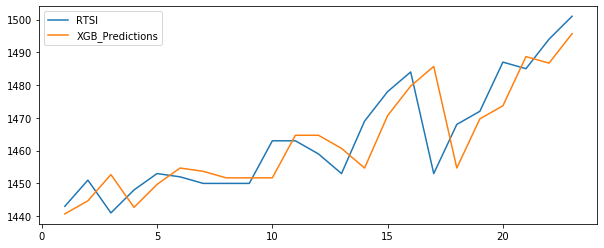

In [60]:
result_df[:23].plot(figsize=(10,4))

### Посчитаем Коэффициент детерминации для реальных данных и предсказания

In [61]:
from sklearn.metrics import mean_squared_error, r2_score
R2 = r2_score(result_df[:23].RTSI, result_df[:23].XGB_Predictions)

In [62]:
print(R2)

0.6483617707969003
